# Visual evaluation of top FFT matches based on similarity on clean data

In [1]:
import numpy as np
import sys
import csv
import scipy.io as sio
from scipy.fftpack import fft, ifft
from sklearn.metrics import mean_squared_error
from math import sqrt
import os
import operator
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image

In [2]:
%matplotlib inline

In [3]:
#base_dir = '/home/ibanez/data/amnh/darwin_notes/'
base_dir = '/data/amnh/darwin/'
curves_fft_dir = base_dir + 'image_csvs_fft/'
fft_similarity_dir = base_dir + 'fft_similarity_clean/'
base_image_dir = base_dir + 'images/'
base_fft_dir = base_dir + 'image_csvs_fft/'
base_csv_dir = base_dir + 'image_csvs/'

In [4]:
top_matches = pd.read_csv(base_dir + 'top_items_sorted.txt', index_col=False, header=None, sep=' ');
top_matches.columns = ["image1","image2","fft_score"]
top_matches.head()

,image1,image2,fft_score
0,MS-DAR-00048-000-00189_south,MS-DAR-00048-000-00189_north_fft.mat,0.999921
1,MS-DAR-00089-000-00017_north,MS-DAR-00205-00002-000-00431_north_fft.mat,0.999893
2,MS-DAR-00087-000-00010_south,MS-DAR-00087-000-00008_north_fft.mat,0.999853
3,MS-DAR-00085-000-00150_south,MS-DAR-00084-00002-000-00307_north_fft.mat,0.999843
4,MS-DAR-00209-00009-000-00088_south,MS-DAR-00209-00009-000-00168_north_fft.mat,0.999837


In [5]:
def save_match(row_index):
    with open("/data/amnh/darwin/confirmed_matches.csv", "a+") as f:        
        image1_basename = top_matches["image1"][row_index]
        image2_basename = top_matches["image2"][row_index]
        fft_score = top_matches["fft_score"][row_index]
        print(image1_basename, image2_basename, fft_score)
        image1_filename = image1_basename[:-6] + '.jpg'
        image2_filename = image2_basename[:-14] + '.jpg'
        print(image1_filename)
        print(image2_filename)
        
        if 'south' in image1_basename:
            f.write("{},{},{}\n".format(image2_filename, image1_filename, fft_score))
        else:
            f.write("{},{},{}\n".format(image1_filename, image2_filename, fft_score))

In [6]:
def check_match_curves(row_index):
    image1_basename = top_matches["image1"][row_index]
    image2_basename = top_matches["image2"][row_index]
    fft_score = top_matches["fft_score"][row_index]
    fft1_filename = base_fft_dir + image1_basename + '_fft.mat'
    fft2_filename = base_fft_dir + image2_basename
    curve1_filename = base_csv_dir + image1_basename + '.csv'
    curve2_filename = base_csv_dir + image2_basename[:-8] + '.csv'
    if 'south' in image1_basename and 'south' in image2_basename:
        print('CONFLICTING BORDERS!')
        return
    if 'north' in image1_basename and 'north' in image2_basename:
        print('CONFLICTING BORDERS!')
        return
    fft1 = sio.loadmat(fft1_filename)['fft']
    fft2 = sio.loadmat(fft2_filename)['fft']
    curve1restored = np.real(ifft(fft1))
    curve2restored = np.real(ifft(fft2))
    curve1xy = pd.read_csv(curve1_filename)
    curve2xy = pd.read_csv(curve2_filename)
    curve1xyn = curve1xy - curve1xy.mean()
    curve2xyn = curve2xy - curve2xy.mean()
    curve1y = curve1xyn.ix[:,1] 
    curve2y = curve2xyn.ix[:,1]
    commonsize = min(curve1y.size, curve2y.size)
    curve1yt = curve1y[:commonsize]
    curve2yt = curve2y[:commonsize]
    rms = sqrt(mean_squared_error(curve1yt,curve2yt))
    print(rms)
    print(curve1_filename)
    print(curve2_filename)
    plt.figure()
    plt.plot(curve1y)
    plt.plot(curve2y)

In [7]:
def compute_match_curves(row_index):
    image1_basename = top_matches["image1"][row_index]
    image2_basename = top_matches["image2"][row_index]
    fft_score = top_matches["fft_score"][row_index]
    image1_filename = image1_basename[:-6] + '.jpg'
    image2_filename = image2_basename[:-14] + '.jpg'
    fft1_filename = base_fft_dir + image1_basename + '_fft.mat'
    fft2_filename = base_fft_dir + image2_basename
    curve1_filename = base_csv_dir + image1_basename + '.csv'
    curve2_filename = base_csv_dir + image2_basename[:-8] + '.csv'
    curve1xy = pd.read_csv(curve1_filename)
    curve2xy = pd.read_csv(curve2_filename)
    curve1xyn = curve1xy - curve1xy.mean()
    curve2xyn = curve2xy - curve2xy.mean()
    curve1y = curve1xyn.ix[:,1] 
    curve2y = curve2xyn.ix[:,1]
    commonsize = min(curve1y.size, curve2y.size)
    curve1yt = curve1y[:commonsize]
    curve2yt = curve2y[:commonsize]
    pow1 = sqrt((curve1yt**2).sum())
    pow2 = sqrt((curve2yt**2).sum())
    rms = sqrt(mean_squared_error(curve1yt,curve2yt))
    if 'south' in image1_basename and 'south' in image2_basename:
        rms = 0.5 # force it to the bottom of the pile
    if 'north' in image1_basename and 'north' in image2_basename:
        rms = 0.5 # force it to the bottom of the pile
    return rms, fft_score, row_index, pow1, pow2, image1_filename, image2_filename

In [8]:
rmss = [compute_match_curves(x) for x in range(0,100)]

In [9]:
review = pd.DataFrame(sorted(rmss,key=operator.itemgetter(3)))

In [10]:
review.head()

,0,1,2,3,4,5,6
0,0.088407,0.999619,18,0.695093,1.629041,MS-DAR-00209-00010-000-00150.jpg,MS-DAR-00209-00014-000-00124.jpg
1,0.052801,0.999484,35,0.809243,1.031504,MS-DAR-00053-00001-000-00038.jpg,MS-DAR-00003-000-00285.jpg
2,0.500000,0.999111,89,0.879807,2.908581,MS-DAR-00205-00009-000-00712.jpg,MS-DAR-00209-00009-000-00070.jpg
3,0.500000,0.999266,65,0.895806,2.397581,MS-DAR-00058-00001-000-00082.jpg,MS-DAR-00083-000-00144.jpg
4,0.133498,0.999921,0,0.917453,0.913018,MS-DAR-00048-000-00189.jpg,MS-DAR-00048-000-00189.jpg


In [11]:
review.tail()

,0,1,2,3,4,5,6
95,0.007774,0.999662,14,11.384572,10.930244,MS-DAR-00209-00010-000-00084.jpg,MS-DAR-00209-00014-000-00016.jpg
96,0.016679,0.999689,11,11.608279,10.575897,MS-DAR-00085-000-00151.jpg,MS-DAR-00084-00002-000-00308.jpg
97,0.010436,0.999837,4,12.335210,11.661802,MS-DAR-00209-00009-000-00088.jpg,MS-DAR-00209-00009-000-00168.jpg
98,0.500000,0.999509,27,12.847964,2.116071,MS-DAR-00205-00007-000-00512.jpg,MS-DAR-00057-000-00308.jpg
99,0.181807,0.999199,78,14.304648,2.097219,MS-DAR-00087-000-00363.jpg,MS-DAR-00012-000-00385.jpg


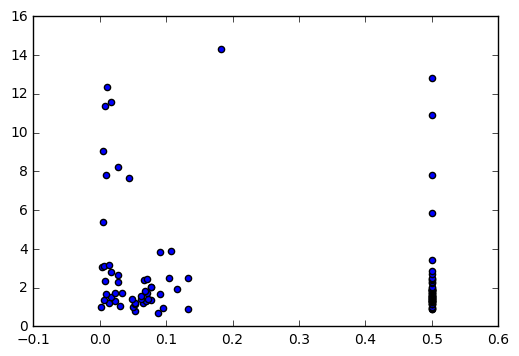

In [12]:
plt.scatter(review[0], review[3])

0.007774177767876896
/data/amnh/darwin/image_csvs/MS-DAR-00209-00010-000-00084_south.csv
/data/amnh/darwin/image_csvs/MS-DAR-00209-00014-000-00016_north.csv


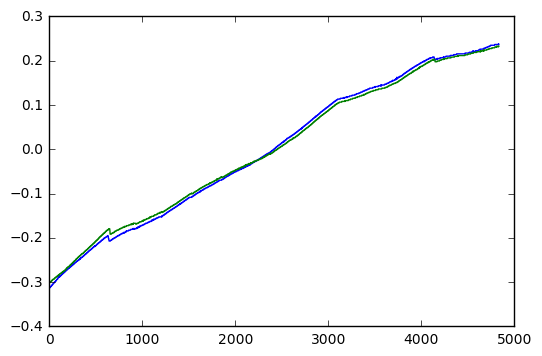

In [13]:
check_match_curves(14)